CCDR Hazard Analysis Notebook
Developed by M. Amadio and T. Iwanaga

In [7]:
from common import *  # import necessary packages

%matplotlib inline

c:\Users\Zia\.conda\envs\eth_climate\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
from IPython.core.debugger import Pdb

In [9]:
country_code_map = {
    "BGD": 'BD',
    "ETH": 'ET'
}

In [10]:
def damage_factor_builtup(x):
    """A polynomial fit to average damage across builtup land cover relative 
    to water depth in meters in Asia/Africa/ LAC.

    The sectors are commercial, industry, transport, infrastructure and residential.

    Values are capped between 0 and 1, where values >= 6m = 1

    References
    ----------
    .. [1] JRC, 2017
    """
    return np.maximum(0.0, np.minimum(1.0, -0.0028*x**3 + 0.0362*x**2 + 0.0095*x)) # Floods - AFRICA
    #return np.maximum(0.0, np.minimum(1.0, 0.9981236 - 0.9946279*np.exp(-1.711056*x))) # Floods - LAC
    #return np.maximum(0.0, np.minimum(1.0, 0.00723*x**3 - 0.1000*x**2 + 0.5060*x)) # Floods - ASIA

In [11]:
def damage_factor_agri(x):
    """A polynomial fit to average damage across agricultural land cover relative 
    to water depth in meters in Globally.

    Values are capped between 0 and 1, where values >= 6m = 1

    References
    ----------
    .. [1] JRC, 2017
    """
    return np.maximum(0.0, np.minimum(1.0, 0.00723*x**3 - 0.1*x**2 + 0.506*x))


In [12]:
def mortality_factor(x):
    """A polynomial fit to average population mortality due to nearby flooding.

    References
    ----------
    .. [1] Jonkman et al, 2008
    """
    return np.maximum(0.0, np.minimum(1.0, 0.985/(1+np.exp(6.32-1.412*x))))

In [13]:
def preview_impact_func(bt):
    
    if exp_cat_dd.value == 'pop':
        damage_factor = mortality_factor
    elif exp_cat_dd.value == 'builtup':
        damage_factor = damage_factor_builtup
    elif exp_cat_dd.value == 'agri':
        damage_factor = damage_factor_agri
    else:
        ValueError("Unknown exposure category")
    
    steps = np.arange(0, 6, 0.1)
    with output:
        output.clear_output()

        fig, ax = plt.subplots()
        line, = ax.plot([damage_factor(x) for x in steps])
        ax.grid(True)
        
        label_steps = range(0, len(steps)+10, 10)
        ax.xaxis.set_ticks(label_steps)
        ax.xaxis.set_ticklabels([i / 10 for i in label_steps])
        ax.set_xlabel("Hazard intensity")
        ax.set_ylabel("Impact Factor")
        
        display(fig)

In [14]:
def run_analysis(rb):
    with output:
        output.clear_output()
        rb.disabled = True
        preview_impact_button.disabled = True
        print("Running analysis...")
        
    analysis_type = analysis_app_dd.value

    if analysis_type == "Classes":
        # Ensure class threshold values are valid

        bin_seq = [w.value for w in class_edges.values()]        
        seq = np.all([True if bin_seq[i] < bin_seq[i+1] else False for i in range(0, len(bin_seq)-1)])
        
        if not seq:
            ValueError("Class thresholds are not sequential. Lower classes must be less than class thresholds above.")
            rb.disabled = False
            preview_impact_button.disabled = False
            return
        
        max_bin_value = np.max(bin_seq)
        max_haz_threshold = max_bin_value + 1e-4
        bin_seq = bin_seq + [np.inf]
        num_bins = len(bin_seq)

    # Get user input
    country = country_dd.value
    exp_cat = exp_cat_dd.value
    time_horizon = time_horizon_dd.value
    rcp_scenario = rcp_scenario_dd.value

    target_ADM = adm_dd.value
    adm_name = target_ADM.replace('_', '')

    if analysis_type == "Classes":
        min_haz_threshold = class_edges['class_1'].value
    else:
        min_haz_threshold = min_haz_slider.value

    valid_RPs = [10,20,50,75, 100,200,500]

    # Data file locations

    exposure_dir = f"{DATA_DIR}/EXP/{country}"
    if exp_cat_dd.value == 'pop':
        damage_factor = mortality_factor
        exp_raster_fn = f"{exposure_dir}_POP.tif"
    elif exp_cat_dd.value == 'builtup':
        damage_factor = damage_factor_builtup
        exp_raster_fn = f"{exposure_dir}_BU.tif"
    elif exp_cat_dd.value == 'agri':
        damage_factor = damage_factor_agri
        exp_raster_fn = f"{exposure_dir}_AGR.tif"
    else:
        ValueError(f"Missing or unknown data layer {exp_cat_dd.value}")

    # Hazard data location
    flood_RP_data_loc = f"{DATA_DIR}/HZD"

    # Run analysis
    
    # Open exposure dataset
    exposure_rst = rxr.open_rasterio(exp_raster_fn)

    # Indicate -1 values as representing no data.
    exposure_rst.rio.write_nodata(-1, inplace=True)

    # Load ADM based on country code value
    try:
        adm_dataset = gpd.read_file(os.path.join(DATA_DIR, f"ADM/{country}_ADM.gpkg"), layer=f"{country}_{adm_name}")
    except ValueError:
        print("Missing ADM layer!")
        
    adm_data = adm_dataset.loc[adm_dataset.ADM0_CODE == country_code_map[country], :]
    
    # Get all ADM code/name columns to save with results
    adm_cols = adm_data.columns
    all_adm_codes = adm_data.columns.str.contains("_CODE")
    all_adm_names = adm_data.columns.str.contains("_NAME")
    
    all_adm_name_tmp = adm_cols[all_adm_names].tolist()
    all_adm_code_tmp = adm_cols[all_adm_codes].to_list()

    result_df = adm_data.loc[:, all_adm_code_tmp + all_adm_name_tmp + ["geometry"]]
    
    # Prep result structure
    if analysis_type == "Function":
        exp_sum_cols = [f"RP{rp_i}_exp_tot" for rp_i in valid_RPs]
        EAI_cols = [f"RP{rp_i}_EAI" for rp_i in valid_RPs]
        result_df.loc[:, exp_sum_cols + EAI_cols] = 0
        
    # Get total exposure for each ADM region
    exp_per_ADM = gen_zonal_stats(vectors=adm_data["geometry"], raster=exp_raster_fn, stats=["sum"])
    result_df[f"{adm_name}_{exp_cat}"] = [x['sum'] for x in exp_per_ADM]

    for rp in valid_RPs:
        # Probability of return period
        # Essentially the same as 1/RP, but accounts for cases where RP == 1
        freq = 1 - np.exp(-1/rp)

        # Load corresponding flood dataset
        flood_rst = rxr.open_rasterio(os.path.join(flood_RP_data_loc, f"{country}_FL_RP{rp}.tif"))

        # Reproject and clip raster to same bounds as exposure data
        flood_rst = flood_rst.rio.reproject_match(exposure_rst)
        
        # Get raw array values for exposure and hazard layer
        flood_arr = flood_rst[0].values
        flood_arr[flood_arr < min_haz_threshold] = np.nan  # Set values below min threshold to nan
        
        if analysis_type == "Function":
            # Assign impact factor (this is F_i)
            if exp_cat_dd.value == 'pop':
                impact_arr = mortality_factor(flood_arr)
            elif exp_cat_dd.value == 'builtup':
                impact_arr = damage_factor_builtup(flood_arr)
            elif exp_cat_dd.value == 'agri':
                impact_arr = damage_factor_agri(flood_arr)

            # Create raster from array
            impact_rst = xr.DataArray(np.array([impact_arr]).astype(np.float32), 
                                      coords=flood_rst.coords, 
                                      dims=flood_rst.dims)

            if save_inter_rst_chk.value:
                impact_rst.rio.to_raster(os.path.join(OUTPUT_DIR, f"{country}_FL_{rp}_{exp_cat}_flood_imp_factor.tif"))
        else:
            impact_rst = flood_rst

        # Calculate affected exposure in ADM
        # Filter down to valid areas
        valid_impact_areas = impact_rst.values > 0
        affected_exp_rst = exposure_rst.where(valid_impact_areas)  # Get total exposure in affected areas
        affected_exp_rst = affected_exp_rst.where(affected_exp_rst > 0)  # Out of the above, get areas that have people
        
        if save_inter_rst_chk.value:
            affected_exp_rst.rio.to_raster(os.path.join(OUTPUT_DIR, f"{country}_FL_{rp}_{exp_cat}_flood_affected_.tif"))
               
        # Conduct analyses for classes
        if analysis_type == "Classes":
            flood_arr[np.isnan(flood_arr)] = 0  # Set NaNs to 0
            flood_arr[flood_arr > max_bin_value] = max_haz_threshold  # Cap large values to maximum threshold value

            # Assign bin values to raster data
            # Follows: x_{i-1} <= x_{i} < x_{i+1}
            bin_idx = np.digitize(flood_arr, bin_seq)

            for bin_x in range(1, num_bins):
                impact_class = gen_zonal_stats(vectors=adm_data["geometry"], raster=np.array(bin_idx == bin_x).astype(int) * affected_exp_rst.data[0],
                                    stats=["sum"], affine=affected_exp_rst.rio.transform(), nodata=np.nan)
                result_df[f"RP{rp}_{exp_cat}_C{bin_x}"] = [x['sum'] for x in impact_class]
            # end
            
            C_cols = result_df.columns.str.contains(f"RP{rp}_{exp_cat}_C")
            result_df[f"RP{rp}_{exp_cat}_tot"] = result_df.loc[:, C_cols].sum(axis=1)
            
            continue

        # Calculate degree on impact over Exposure category
        impact_exp_rst = affected_exp_rst * impact_rst.where(valid_impact_areas)  # Get impacted exposure in affected areas
        
        if save_inter_rst_chk.value:
            impact_exp_rst.rio.to_raster(os.path.join(OUTPUT_DIR, f"{country}_FL_{exp_cat}_{rp}_impact.tif"))

        
        impact_exp_per_ADM = gen_zonal_stats(vectors=adm_data["geometry"], raster=impact_exp_rst.data[0], 
                                             stats=["sum"], affine=impact_exp_rst.rio.transform(), nodata=0)
        result_df[f"RP{rp}_{exp_cat}_imp"] = [x['sum'] for x in impact_exp_per_ADM]

        # EAI_i := F_i * freq
        EAI_i = impact_exp_rst.where(valid_impact_areas) * freq

        if save_inter_rst_chk.value:
            # Save intermediate file if requested
            EAI_i.rio.to_raster(os.path.join(OUTPUT_DIR, f"{country}_FL_{exp_cat}_{rp}_EAI.tif"))

        # Get affected exposure per ADM
        affected_exp_per_ADM = gen_zonal_stats(vectors=adm_data["geometry"], raster=affected_exp_rst.data[0], 
                                            stats=["sum"], affine=affected_exp_rst.rio.transform(), nodata=0)
        result_df[f"RP{rp}_{exp_cat}_tot"] = [x['sum'] for x in affected_exp_per_ADM]


        EAI_per_ADM = gen_zonal_stats(vectors=adm_data["geometry"], raster=EAI_i.data[0],
                                    stats=["sum"], affine=EAI_i.rio.transform(), nodata=0)
        result_df[f"RP{rp}_EAI"] = [x['sum'] for x in EAI_per_ADM]
    # End RP loop

    if analysis_type == "Function":
        # Sum all EAI to get total EAI across all RPs
        result_df.loc[:, f"{exp_cat}_EAI"] = result_df.loc[:, result_df.columns.str.contains('_EAI')].sum(axis=1)

        # Calculate Exp_EAI% (Percent affected exposure per year)
        result_df.loc[:, f"{exp_cat}_EAI%"] = (result_df.loc[:, f"{exp_cat}_EAI"] / result_df.loc[:, f"{adm_name}_{exp_cat}"]) * 100.0
    
        # Reorder - need ADM code, name, and exp at the front regardless of ADM level
        result_df = result_df.loc[:, all_adm_code_tmp + all_adm_name_tmp +
                                [f"{adm_name}_{exp_cat}", f"RP10_{exp_cat}_tot",f"RP20_{exp_cat}_tot",f"RP50_{exp_cat}_tot" ,f"RP75_{exp_cat}_tot", f"RP100_{exp_cat}_tot",f"RP200_{exp_cat}_tot", f"RP500_{exp_cat}_tot",
                                f"RP10_{exp_cat}_imp", f"RP20_{exp_cat}_imp",f"RP50_{exp_cat}_imp", f"RP75_{exp_cat}_imp", f"RP100_{exp_cat}_imp", f"RP200_{exp_cat}_imp", f"RP500_{exp_cat}_imp", 
                                "RP10_EAI", "RP20_EAI", "RP50_EAI", "RP75_EAI", "RP100_EAI", "RP200_EAI", "RP500_EAI", f"{exp_cat}_EAI", f"{exp_cat}_EAI%", "geometry"]]

    # Round to three decimal places to avoid giving the impression of high precision
    result_df = result_df.round(3)

    # Write table of total population in each class, in each ADM2
    df_cols = result_df.columns

    no_geom = result_df.loc[:, df_cols[~df_cols.isin(['geometry'])]].fillna(0)
    if analysis_type == "Function":
        no_geom.to_csv(os.path.join(OUTPUT_DIR, f"{country}_FL_{adm_name}_{exp_cat}_EAI.csv"), index=False)
        result_df.to_file(os.path.join(OUTPUT_DIR, f"{country}_FL_{adm_name}_{exp_cat}_EAI.gpkg"))
    elif analysis_type == "Classes":
        no_geom.to_csv(os.path.join(OUTPUT_DIR, f"{country}_FL_{adm_name}_{exp_cat}_class.csv"), index=False)
        result_df.to_file(os.path.join(OUTPUT_DIR, f"{country}_FL_{adm_name}_{exp_cat}_class.gpkg"))

    with output:
        print("Finished analysis.")
        rb.disabled = False

    if preview_chk.value:
        with output:
            if analysis_type == "Function":
                display(result_df.explore(column=f'{exp_cat}_EAI', cmap='plasma'))

                exp_total = result_df.columns.str.contains(f'_{exp_cat}_tot')
                exp_imp = result_df.columns.str.contains(f'_{exp_cat}_imp')
                exp_EAI = result_df.columns.str.contains(f'_{exp_cat}_EAI')
                
                result_df.loc[:, ]
            elif analysis_type == "Classes":
                # TODO: C1 Column selected for example display only!
                display(result_df.explore(column=f'RP10_{exp_cat}_C1', cmap='plasma'))


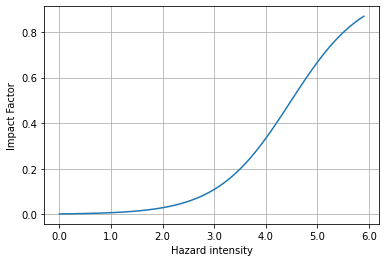

In [15]:
# Data option widgets
country_dd = widgets.Dropdown(
    options=[('Bangladesh', 'BGD'), ('Ethiopia', 'ETH')],
    value='ETH',
    description='Country:',
    style={'description_width': 'initial'}
)

exp_cat_dd = widgets.Dropdown(
    options=[("Population", "pop"), ("Built-up", "builtup"), ("Agriculture", "agri")],
    value='pop',
    description='Exposure Category:',
    style={'description_width': 'initial'}
)

adm_dd = widgets.Dropdown(
    options=['ADM1', 'ADM2', 'ADM3', 'ADM4'],
    value='ADM2',
    description='Administrative Unit Level:',
    style={'description_width': 'initial'}
)

min_haz_slider = widgets.FloatSlider(
    value=0.5,
    min=0.01,
    max=10.0,
    step=0.01,
    description="Minimum Hazard Threshold:",
    style={'description_width': 'initial'}
)

# Class value inputs
class_edges = OrderedDict({
    f'class_{i+1}': widgets.BoundedFloatText(
        value=k,
        min=0.01,
        max=10.0,
        step=0.01,
        description=f'Class {i+1}:',
        tooltip=f'Minimum value of class {i+1}. Value must be less than the next entry.',
        disabled=True
    ) for (i,k) in enumerate([0.01, 0.15, 0.5, 1, 1.5, 2])
})

# Climate component (in addition to baseline risk - load external module)

time_horizon_dd = widgets.Dropdown(
    options=[2040, 2060, 2080, 2100],
    value=2060,
    description='Time Horizon:',
    style={'description_width': 'initial'}
)

rcp_scenario_dd = widgets.Dropdown(
    options=["2.6", "4.5", "8.5"],
    value="4.5",
    description='RCP Scenario:',
    style={'description_width': 'initial'}
)

analysis_app_dd = widgets.Dropdown(
    options=["Classes", "Function"],
    value="Function",
    description='Analysis Approach:',
    style={'description_width': 'initial'}
)

# User action widgets
save_inter_rst_chk = widgets.Checkbox(
    value=False,
    description='Export Intermediate Rasters',
    tooltip='Save rasters generated between each step (saves to nominated output directory)',
    disabled=False,
    indent=False
)

# Display results after runs
preview_chk = widgets.Checkbox(
    value=True,
    description='Preview results',
    tooltip='Display result after analysis',
    disabled=False
)


# Run button to perform analysis
run_button = widgets.Button(
    description='Run Analysis',
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to run analysis with selected options',
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)


# Button to preview hazard impact function
preview_impact_button = widgets.Button(
    description='Preview Impact Function',
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Show preview of impact function',
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)

reset_display_button = widgets.Button(
    description='Reset',
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Reset display',
    # icon='check' # (FontAwesome names without the `fa-` prefix)
)


def reset_display(bt):
    output.clear_output()
    run_button.disabled = False
    
    if analysis_app_dd.value == "Function":
        preview_impact_button.disabled = False

run_button.on_click(run_analysis)
preview_impact_button.on_click(preview_impact_func)
reset_display_button.on_click(reset_display)


def analysis_change(change):
    if change.new == "Classes":
        min_haz_slider.disabled = True
        preview_impact_button.disabled = True
        preview_chk.disabled = True
        preview_chk.value = False
        disable_class = False
        
    else:
        min_haz_slider.disabled = False
        preview_impact_button.disabled = False
        preview_chk.disabled = False
        preview_chk.value = True
        disable_class = True
        
    
    for w in class_edges.values():
        w.disabled = disable_class

analysis_app_dd.observe(analysis_change, names='value')


# preview_button.on_click()

# class_range = range(3, 11)  # remember that python uses end-exclusive range, so this is 3-10
# selected_bin_edges = [0.5, 1, 1.5, 2, 2.5, 3]
# min_haz_threshold = np.min(selected_bin_edges)  # determine min/max values from user-selected edges
# max_haz_threshold = np.max(selected_bin_edges)
# selected_bin_edges += [np.inf] # add inf last to cover anything above max threshold.

# num_bins = len(selected_bin_edges)-1  # default number of bins, within the range of `class_range`

In [16]:
display(country_dd)
display(exp_cat_dd)
display(adm_dd)
display(analysis_app_dd)
display(min_haz_slider)
[display(w) for w in class_edges.values()]

display(HBox([run_button, preview_chk, save_inter_rst_chk]), 
        preview_impact_button, reset_display_button)

output = widgets.Output()
display(output)

Dropdown(description='Country:', index=1, options=(('Bangladesh', 'BGD'), ('Ethiopia', 'ETH')), style=Descript…

Dropdown(description='Exposure Category:', options=(('Population', 'pop'), ('Built-up', 'builtup'), ('Agricult…

Dropdown(description='Administrative Unit Level:', index=1, options=('ADM1', 'ADM2', 'ADM3', 'ADM4'), style=De…

Dropdown(description='Analysis Approach:', index=1, options=('Classes', 'Function'), style=DescriptionStyle(de…

FloatSlider(value=0.5, description='Minimum Hazard Threshold:', max=10.0, min=0.01, step=0.01, style=SliderSty…

BoundedFloatText(value=0.01, description='Class 1:', disabled=True, max=10.0, min=0.01, step=0.01)

BoundedFloatText(value=0.15, description='Class 2:', disabled=True, max=10.0, min=0.01, step=0.01)

BoundedFloatText(value=0.5, description='Class 3:', disabled=True, max=10.0, min=0.01, step=0.01)

BoundedFloatText(value=1.0, description='Class 4:', disabled=True, max=10.0, min=0.01, step=0.01)

BoundedFloatText(value=1.5, description='Class 5:', disabled=True, max=10.0, min=0.01, step=0.01)

BoundedFloatText(value=2.0, description='Class 6:', disabled=True, max=10.0, min=0.01, step=0.01)

Button(description='Preview Impact Function', style=ButtonStyle(), tooltip='Show preview of impact function')

Button(description='Reset', style=ButtonStyle(), tooltip='Reset display')

Output()